# NLP Course Assignment Epsiode 1
## Question 3 b)

This task focusses on multiclass text classification. The New York Times headlines and topics data set from Amber Ellen Boydstun: http://www.amber-boydstun.com/supplementary-information-for-making-the-news.html

The code for this task makes use of the following packages: scikit-learn, NLTK, pandas and matplotlib 

$\pagenumbering{gobble}$

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# load data set
nyt_data_set = pd.read_csv(
    'boydstun_nyt_frontpage_dataset_utf8.csv',
    index_col='id'
    )

display(nyt_data_set.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31034 entries, 1 to 31034
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        31034 non-null  int64 
 1   majortopic  31034 non-null  int64 
 2   subtopic    31034 non-null  int64 
 3   title       31031 non-null  object
 4   summary     30976 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.4+ MB


None

The columns 'title' and 'summary' can be used to predict the column 'majortopic'. There are a few missing values in these columns, for simplicity, we drop them.

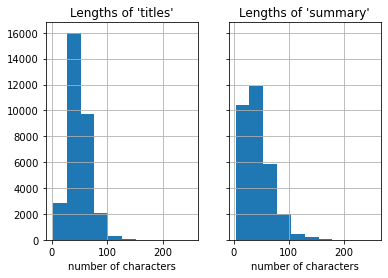

In [2]:
# drop rows with missing values in relevant columns
nyt_data_set.dropna(subset=['title', 'summary', 'majortopic'], inplace=True)

# create histograms of the string lengths
fig, axs = plt.subplots(1, 2, sharey=True)
nyt_data_set['title'].apply(len).hist(ax=axs[0])
axs[0].set(xlabel='number of characters', title='Lengths of \'titles\'')
nyt_data_set['summary'].apply(len).hist(axes=axs[1])
axs[1].set(xlabel='number of characters', title='Lengths of \'summary\'')
plt.show()


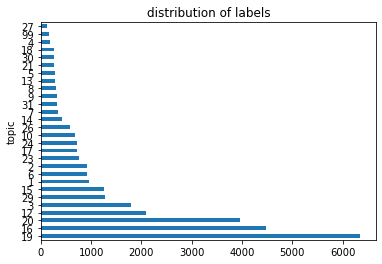

In [3]:
# explore how balanced the data set labels are
fig, ax = plt.subplots()
nyt_data_set['majortopic'].value_counts().plot.barh()
ax.set(ylabel='topic', title='distribution of labels')
plt.show()

The titles and summarys are rather short but their lengths do not vary very stongly. There are 28 different topics as labels. The set is very inbalanced.

The topic corresponding to each code can be found on https://www.comparativeagendas.net/pages/master-codebook

The two columns 'title' and 'summary' are concatenated and the data set is split into 20% development, 20% test and 60% training data.

In [4]:
# size of the test and development set
n_test = int(nyt_data_set.shape[0]*0.2)
n_dev = int(nyt_data_set.shape[0]*0.2)

# split into distinct sets - title and summary are combined to one string
headlines_train, headlines_test, labels_train, labels_test = train_test_split(
    (nyt_data_set['title'] + ' ' + nyt_data_set['summary']).to_list(),
    nyt_data_set['majortopic'].to_list(),
    test_size=n_test,
    random_state=42
    )

headlines_train, headlines_dev, labels_train, labels_dev = train_test_split(
    headlines_train,
    labels_train,
    test_size=n_dev,
    random_state=42
    )

The following preprocessing steps are performed:
* tokenization
* removal of non-alphabetical tokens
* removal of common stopwords
* lemmatization

In [5]:
def preprocess_headline(string):

    # tokenize input
    tokens = word_tokenize(string)

    # remove non-alphabetical tokens
    tokens_alpha = [w.lower() for w in tokens if w.isalpha()]

    # remove stopwords
    tokens_no_stops = [w for w in tokens_alpha
                       if w not in stopwords.words('english')]

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens_lemma = [lemmatizer.lemmatize(w) for w in tokens_no_stops]

    return tokens_lemma


headlines_train_pre = [preprocess_headline(txt) for txt in headlines_train]
headlines_dev_pre = [preprocess_headline(txt) for txt in headlines_dev]
headlines_test_pre = [preprocess_headline(txt) for txt in headlines_test]

(i) Bag of word vectors are used as features to train an unregularized logistic regression model with different vocabulary sizes. The performance is then evaluated on the test set.

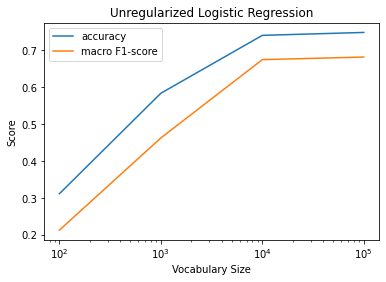

In [6]:
def evaluate_model(voc_size, penalty='none', l2_C=1, solver='lbfgs',):

    # headlines are already tokenized, therefore a dummy function
    # is passed to the vectorizer
    def dummy_tokenizer(text):
        return text

    # BOW vectorization of the training and test reviews
    vectorizer = CountVectorizer(
        lowercase=False,
        tokenizer=dummy_tokenizer,
        token_pattern=None,
        max_features=voc_size
        )

    vectorizer.fit(headlines_train_pre)
    headlines_train_bow = vectorizer.transform(headlines_train_pre)
    headlines_test_bow = vectorizer.transform(headlines_test_pre)

    # train and predict with logistic regression
    clf = LogisticRegression(C=l2_C, penalty=penalty, max_iter=5000, class_weight='balanced', solver=solver)
    clf.fit(headlines_train_bow, labels_train)
    labels_test_pred = clf.predict(headlines_test_bow)

    acc = accuracy_score(labels_test, labels_test_pred)
    f1 = f1_score(labels_test, labels_test_pred, average='macro')

    return acc, f1


# vocabulary size
voc_size_lst = [10**2, 10**3, 10**4, 10**5]

acc_lst = []
f1_lst = []

for voc_size in voc_size_lst:
    acc, f1 = evaluate_model(voc_size, solver='saga')
    acc_lst.append(acc)
    f1_lst.append(f1)


fig, ax = plt.subplots()
ax.plot(voc_size_lst, acc_lst, label='accuracy')
ax.plot(voc_size_lst, f1_lst, label='macro F1-score')
ax.set_xscale('log')
ax.set(
        title='Unregularized Logistic Regression',
        ylabel='Score',
        xlabel='Vocabulary Size'
        )
ax.legend(loc='best')

plt.show()

(ii) To improve performance, an L<sub>2</sub> penalty is applied and tuned on the performance set for each vocabulary size.

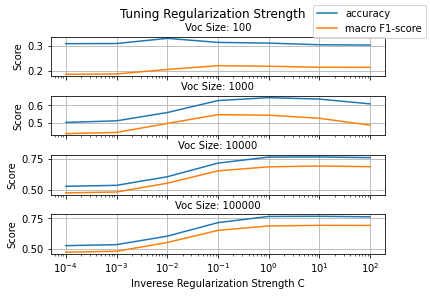

In [7]:
def tune_l2(voc_size, C_list):

    # headlines are already tokenized, therefore a dummy function
    # is passed to the vectorizer
    def dummy_tokenizer(text):
        return text

    # BOW vectorization of the training and test reviews
    vectorizer = CountVectorizer(
        lowercase=False,
        tokenizer=dummy_tokenizer,
        token_pattern=None,
        max_features=voc_size
        )

    vectorizer.fit(headlines_train_pre)
    headlines_train_bow = vectorizer.transform(headlines_train_pre)
    headlines_dev_bow = vectorizer.transform(headlines_dev_pre)

    acc_list = []
    f1_list = []

    for C_ in C_list:

        # train and predict with logistic regression
        clf = LogisticRegression(C=C_, penalty='l2', max_iter=5000, class_weight='balanced')
        clf.fit(headlines_train_bow, labels_train)
        labels_dev_pred = clf.predict(headlines_dev_bow)

        acc_list.append(accuracy_score(labels_dev, labels_dev_pred))
        f1_list.append(f1_score(labels_dev, labels_dev_pred, average='macro'))

    return acc_list, f1_list


# vocabulary size
voc_size_lst = [10**2, 10**3, 10**4, 10**5]

fig, axs = plt.subplots(len(voc_size_lst), 1, sharex=True)

for i, voc_size in enumerate(voc_size_lst):

    # values for C to try
    C_list = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2]

    acc_lst, f1_lst = tune_l2(voc_size, C_list)

    axs[i].plot(C_list, acc_lst)
    axs[i].plot(C_list, f1_lst)
    axs[i].set_xscale('log')
    axs[i].set_title('Voc Size: ' + str(voc_size), size=10)
    axs[i].set_ylabel('Score')
    axs[i].grid()

plt.subplots_adjust(hspace=0.5)
axs[-1].set(xlabel='Inverese Regularization Strength C')
fig.suptitle('Tuning Regularization Strength')
fig.legend(['accuracy', 'macro F1-score'])
plt.show()

For each vocabulary size we apply the regularzation strength which performed best on the development set and evaluate the model again on the test set.

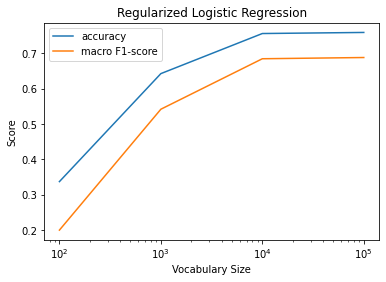

In [8]:
# vocabulary size and the according value for C
voc_size_lst = [10**2, 10**3, 10**4, 10**5]
C_best_lst = [10**-2, 10**0, 10**1, 10**1]

acc_lst = []
f1_lst = []

for voc_size, C_best in zip(voc_size_lst, C_best_lst):
    acc, f1 = evaluate_model(voc_size, penalty='l2', l2_C=C_best)
    acc_lst.append(acc)
    f1_lst.append(f1)


fig, ax = plt.subplots()
ax.plot(voc_size_lst, acc_lst, label='accuracy')
ax.plot(voc_size_lst, f1_lst, label='macro F1-score')
ax.set_xscale('log')
ax.set(
        title='Regularized Logistic Regression',
        ylabel='Score',
        xlabel='Vocabulary Size'
        )
ax.legend(loc='best')

plt.show()

(iii) The accuracy of the classifier increases with the vocabulary size, both in the regularized and the unregularized case. There are many different target classes and the set is heavily inbalanced. To account for that, balanced class weights are used. This approach basically punishes wrong predictions in rare classes harder than in frequent classes. In a small vocabulary, words which are specific to the rare classes and therefore do not appear often, might be lost. This could make it more difficult to predict them correctly and so decreas the overall accuracy.

In the regularized case, the parameter C is the inverse regularization strength. Smaller values specify stronger regularization. If the vocabulary is small, regularization does not have a big influence. With increasing vocabulary size, the choice of the parameter C becomes more important and can boost the accuracy. The more words there are in the vocabulary, the higher dimensional the feature-space will be. More features generally increase the potential to overfit and therefore benefit from regularization.